In [9]:
%reset -f
import xgboost as xgb
print(xgb.__version__)

import warnings
warnings.filterwarnings('ignore', message='.*use_label_encoder.*')

2.1.4


In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

df = pd.read_csv("C:\\Users\\rosas\\OneDrive\\Desktop\\SML\\Project\\US_Accidents_Featured_Engineered.csv")

target_cols = ['Severity_count', 'Severity_mean', 'Severity_max']

drop_from_features = {"grid_id"}

existing = [col for col in drop_from_features if col in df.columns]
missing = [col for col in drop_from_features if col not in df.columns]

# 删除这些列
X = df.drop(columns=existing + target_cols)
y = df[target_cols]
print("After deleting", X.shape)

df_shuffled = shuffle(pd.concat([X, y], axis=1), random_state=42).reset_index(drop=True)
X = df_shuffled.drop(columns=target_cols)
y = df_shuffled[target_cols]


以下列存在，可以删除： ['grid_id']
以下列不在数据中（可忽略）： []
删除后 X 的形状： (11167, 158)


In [ ]:
def manual_regression_kfold_split(X, y, k=5, seed=42, bins=10):
    """
    Perform manual k-fold cross-validation splitting for regression tasks.

    This function divides the continuous target y into quantile-based bins
    to ensure each fold has a similar distribution of target values
    (a stratified-like approach for regression).

    Parameters:
    ----------
    X : pd.DataFrame or np.ndarray
        Feature matrix.
    y : pd.Series or np.ndarray
        Continuous target variable.
    k : int, default=5
        Number of folds.
    seed : int, default=42
        Random seed for reproducibility.
    bins : int, default=10
        Number of quantile bins used to discretize y for stratification.

    Returns:
    -------
    splits : list of tuples
        Each tuple contains (train_indices, test_indices) for one fold.
    """
    
    # Set random seed for reproducibility
    np.random.seed(seed)

    # Discretize the continuous target into quantile-based bins.
    # This ensures roughly equal-sized groups of target values.
    y_bins = pd.qcut(y, q=bins, duplicates='drop')

    # Initialize a list of k empty folds (to store test indices)
    folds = [[] for _ in range(k)]

    # Reset index for consistency when accessing indices later
    y_binned = y_bins.reset_index(drop=True)

    # For each unique bin (group of similar target values)
    for cls in y_binned.unique():
        # Get indices belonging to this bin
        cls_idx = np.where(y_binned == cls)[0]

        # Shuffle indices to ensure random distribution
        np.random.shuffle(cls_idx)

        # Split these indices evenly across k folds
        split = np.array_split(cls_idx, k)

        # Assign each portion to a corresponding fold
        for i in range(k):
            folds[i].extend(split[i])
    
    # Prepare final list of (train, test) index pairs
    splits = []
    for i in range(k):
        # Current fold is test set
        test_idx = np.array(sorted(folds[i]))

        # Remaining indices form the training set
        train_idx = np.array(sorted(np.setdiff1d(np.arange(len(y)), test_idx)))

        # Append the split as a tuple
        splits.append((train_idx, test_idx))

    return splits



Fold 1: Train instances = 8932, Test instances = 2235
Fold 2: Train instances = 8933, Test instances = 2234
Fold 3: Train instances = 8934, Test instances = 2233
Fold 4: Train instances = 8934, Test instances = 2233
Fold 5: Train instances = 8935, Test instances = 2232


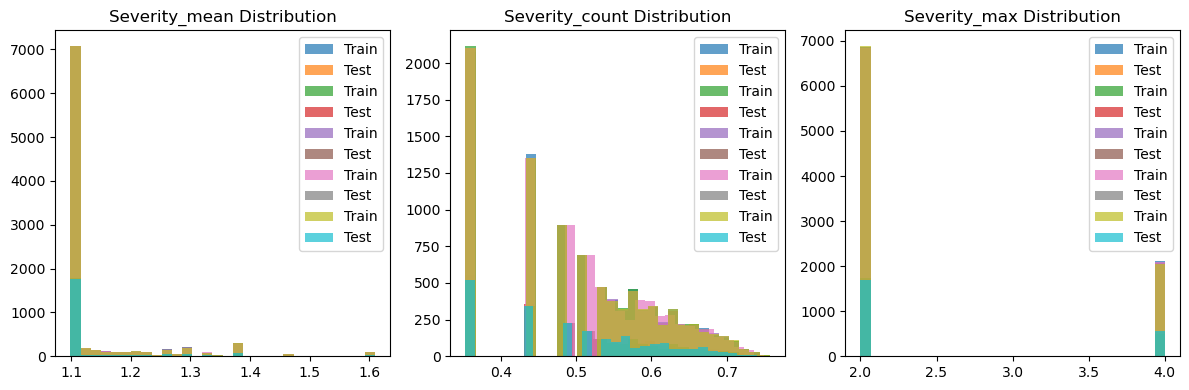

In [ ]:
def test_fold_loop(X, y):
    """
    Visualize and verify the stratified k-fold splits for multiple regression targets.

    This function applies the manual_regression_kfold_split() method to three
    different regression targets ('Severity_mean', 'Severity_count', and 'Severity_max'),
    prints the train/test sizes per fold, and plots histograms to show that 
    the target value distributions are balanced across folds.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.DataFrame
        DataFrame containing target columns: 'Severity_mean', 'Severity_count', and 'Severity_max'.
    """

    # Generate stratified folds for each target variable
    mean_folds = manual_regression_kfold_split(X, y['Severity_mean'], k=5, seed=42)
    count_folds = manual_regression_kfold_split(X, y['Severity_count'], k=5, seed=42)
    max_folds   = manual_regression_kfold_split(X, y['Severity_max'],   k=5, seed=42)

    # Create a figure with three subplots (one for each target)
    plt.figure(figsize=(12, 4))

    # === Plot 1: Severity_mean ===
    for i, (train_idx, test_idx) in enumerate(mean_folds):
        # Print number of samples per fold
        print(f"Fold {i+1}: Train instances = {len(train_idx)}, Test instances = {len(test_idx)}")

        # Overlay train/test distributions for each fold (same subplot)
        plt.subplot(1, 3, 1)
        plt.hist(y['Severity_mean'].iloc[train_idx], bins=30, alpha=0.7, label='Train' if i == 0 else "")
        plt.hist(y['Severity_mean'].iloc[test_idx], bins=30, alpha=0.7, label='Test' if i == 0 else "")
        plt.title('Severity_mean Distribution')
        plt.xlabel('Target Value')
        plt.ylabel('Frequency')
        plt.legend()

    # === Plot 2: Severity_count ===
    for i, (train_idx, test_idx) in enumerate(count_folds):
        plt.subplot(1, 3, 2)
        plt.hist(y['Severity_count'].iloc[train_idx], bins=30, alpha=0.7, label='Train' if i == 0 else "")
        plt.hist(y['Severity_count'].iloc[test_idx], bins=30, alpha=0.7, label='Test' if i == 0 else "")
        plt.title('Severity_count Distribution')
        plt.xlabel('Target Value')
        plt.legend()

    # === Plot 3: Severity_max ===
    for i, (train_idx, test_idx) in enumerate(max_folds):
        plt.subplot(1, 3, 3)
        plt.hist(y['Severity_max'].iloc[train_idx], bins=30, alpha=0.7, label='Train' if i == 0 else "")
        plt.hist(y['Severity_max'].iloc[test_idx], bins=30, alpha=0.7, label='Test' if i == 0 else "")
        plt.title('Severity_max Distribution')
        plt.xlabel('Target Value')
        plt.legend()

    # Adjust layout and display all subplots together
    plt.tight_layout()
    plt.show()

# Run verification for your dataset
test_fold_loop(X, y)

In [ ]:
def nested_cv_xgb_manual(X, y_target, outer_k=10, inner_k=3):
    """
    Perform fully manual nested cross-validation for XGBoost regression.

    This function implements both the outer and inner cross-validation loops
    from scratch, as required in COMP90051 projects. The inner loop performs
    hyperparameter tuning, while the outer loop provides an unbiased performance
    estimate of the tuned model.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y_target : pd.Series
        Target variable for regression.
    outer_k : int, default=10
        Number of folds for outer cross-validation (model evaluation).
    inner_k : int, default=3
        Number of folds for inner cross-validation (hyperparameter tuning).

    Returns
    -------
    results : np.ndarray
        Array of shape (outer_k, 3), containing RMSE, MAE, and R² for each outer fold.
    """

    results = []
    target_name = y_target.name if hasattr(y_target, 'name') else "Unnamed Target"

    # --- Outer cross-validation setup ---
    # Each outer fold will hold out a test split to evaluate generalization.
    outer_folds = manual_regression_kfold_split(X, y_target, k=outer_k, seed=42, bins=10)
    print(f"\n=== Nested CV for target: {target_name} ===")
    print(f"There are {len(outer_folds)} outer folds.")

    # --- Outer loop ---
    for fold_idx, (outer_train_idx, outer_test_idx) in enumerate(outer_folds):
        print(f"\n--- Outer Fold {fold_idx+1} ---")

        # Split into outer train/test
        X_train, X_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train, y_test = y_target.iloc[outer_train_idx], y_target.iloc[outer_test_idx]

        # Initialize variables for inner loop (hyperparameter tuning)
        best_mae = np.inf
        best_params = None

        # --- Inner CV for hyperparameter tuning ---
        inner_folds = manual_regression_kfold_split(X_train, y_train, k=inner_k, seed=fold_idx+1, bins=10)

        # Search space for XGBoost hyperparameters
        for max_depth in [3, 4, 5]:
            for lr in [0.2, 0.25, 0.3]:
                inner_maes = []

                # --- Inner loop ---
                for inner_train_idx, inner_val_idx in inner_folds:
                    # Split training data into inner train/validation
                    X_inner_train = X_train.iloc[inner_train_idx]
                    X_inner_val = X_train.iloc[inner_val_idx]
                    y_inner_train = y_train.iloc[inner_train_idx]
                    y_inner_val = y_train.iloc[inner_val_idx]

                    # Standardize features (fit only on training set)
                    scaler = StandardScaler()
                    X_inner_train = scaler.fit_transform(X_inner_train)
                    X_inner_val = scaler.transform(X_inner_val)

                    # Define and train XGBoost model
                    model = XGBRegressor(
                        max_depth=max_depth,
                        learning_rate=lr,
                        n_estimators=300,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42,
                        objective='reg:squarederror'
                    )

                    model.fit(X_inner_train, y_inner_train)

                    # Validate model on inner validation set
                    preds = model.predict(X_inner_val)
                    mae = mean_absolute_error(y_inner_val, preds)
                    inner_maes.append(mae)

                # Compute average MAE across inner folds
                mean_mae = np.mean(inner_maes)

                # Update best hyperparameters if improvement found
                if mean_mae < best_mae:
                    best_mae = mean_mae
                    best_params = {'max_depth': max_depth, 'learning_rate': lr}

        print(f"Best params from inner CV: {best_params} (MAE={best_mae:.3f})")

        # --- Outer evaluation ---
        # Retrain on full outer training set with best hyperparameters
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = XGBRegressor(
            **best_params,
            n_estimators=300,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            objective='reg:squarederror'
        )

        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)

        # Compute metrics on outer test set
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        results.append([rmse, mae, r2])
        print(f"Fold {fold_idx+1}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

    # --- Final summary across all outer folds ---
    results = np.array(results)
    print(f"\nFinal results for {target_name}:")
    print(f"Mean RMSE = {results[:,0].mean():.3f} ± {results[:,0].std():.3f}")
    print(f"Mean MAE  = {results[:,1].mean():.3f} ± {results[:,1].std():.3f}")
    print(f"Mean R²   = {results[:,2].mean():.3f} ± {results[:,2].std():.3f}")

    return results




=== Nested CV for target: Severity_count ===
There are 10 outer folds.

--- Outer Fold 1 ---
Best params from inner CV: {'max_depth': 5, 'learning_rate': 0.2} (MAE=0.028)
Fold 1: RMSE=0.036, MAE=0.027, R²=0.893

--- Outer Fold 2 ---
Best params from inner CV: {'max_depth': 3, 'learning_rate': 0.2} (MAE=0.028)
Fold 2: RMSE=0.036, MAE=0.027, R²=0.890

--- Outer Fold 3 ---
Best params from inner CV: {'max_depth': 5, 'learning_rate': 0.2} (MAE=0.028)
Fold 3: RMSE=0.036, MAE=0.027, R²=0.883

--- Outer Fold 4 ---
Best params from inner CV: {'max_depth': 4, 'learning_rate': 0.2} (MAE=0.028)
Fold 4: RMSE=0.036, MAE=0.027, R²=0.889

--- Outer Fold 5 ---
Best params from inner CV: {'max_depth': 5, 'learning_rate': 0.2} (MAE=0.028)
Fold 5: RMSE=0.035, MAE=0.026, R²=0.892

--- Outer Fold 6 ---
Best params from inner CV: {'max_depth': 4, 'learning_rate': 0.2} (MAE=0.028)
Fold 6: RMSE=0.037, MAE=0.028, R²=0.885

--- Outer Fold 7 ---
Best params from inner CV: {'max_depth': 4, 'learning_rate': 0.2} 

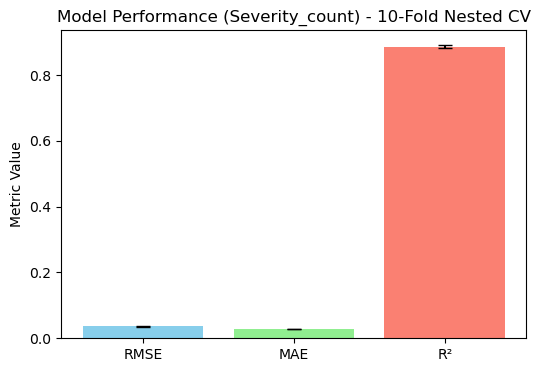


Nested Cross-Validation Results for Severity_mean
RMSE : 0.064 ± 0.004
MAE  : 0.033 ± 0.002
R²   : 0.510 ± 0.041


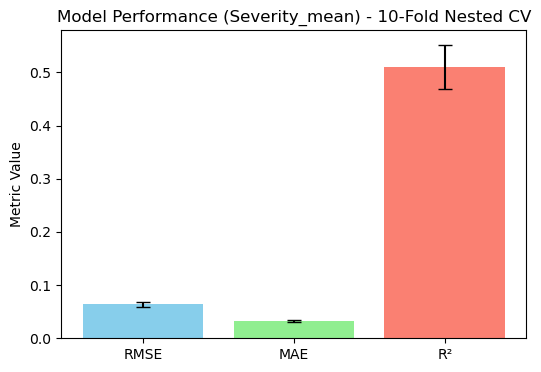


Nested Cross-Validation Results for Severity_max
RMSE : 0.605 ± 0.019
MAE  : 0.410 ± 0.012
R²   : 0.485 ± 0.034


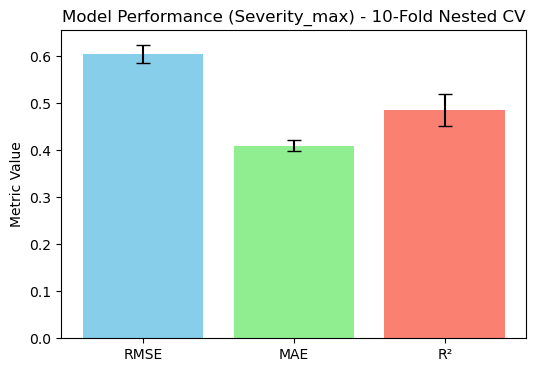

In [ ]:
# ============================================
results_dict = {}
for target in target_cols:
    result = nested_cv_xgb_manual(X, y[target], outer_k=10, inner_k=3)
    results_dict[target] = result

for target, results in results_dict.items():
    rmse_mean, mae_mean, r2_mean = results.mean(axis=0)
    rmse_std, mae_std, r2_std = results.std(axis=0)

    print("\n==========================")
    print(f"Nested Cross-Validation Results for {target}")
    print("==========================")
    print(f"RMSE : {rmse_mean:.3f} ± {rmse_std:.3f}")
    print(f"MAE  : {mae_mean:.3f} ± {mae_std:.3f}")
    print(f"R²   : {r2_mean:.3f} ± {r2_std:.3f}")
    
    metrics = ['RMSE', 'MAE', 'R²']
    means = [rmse_mean, mae_mean, r2_mean]
    stds = [rmse_std, mae_std, r2_std]

    plt.figure(figsize=(6, 4))
    plt.bar(metrics, means, yerr=stds, capsize=5, color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylabel("Metric Value")
    plt.title(f"Model Performance ({target}) - 10-Fold Nested CV")
    plt.show()

In [16]:
def manual_learning_curve_regression(model, X, y, train_fractions=None, k=5, seed=42):
    """
    Computes a manual learning curve for regression tasks using custom K-fold splits.

    Parameters:
        model: regression model (e.g., XGBRegressor)
        X: DataFrame of features
        y: Series of continuous target values
        train_fractions: list of training data fractions (default = [0.1, 0.3, 0.5, 0.7, 1.0])
        k: number of folds
        seed: random seed
    """
    if train_fractions is None:
        train_fractions = [0.1, 0.3, 0.5, 0.7, 1.0]

    np.random.seed(seed)
    splits = manual_regression_kfold_split(X, y, k=k, seed=seed, bins=10)

    results = []

    for frac in train_fractions:
        fold_train_rmse, fold_val_rmse = [], []
        fold_train_mae,  fold_val_mae  = [], []
        fold_train_r2,   fold_val_r2   = [], []

        print(f"\n Current training fraction: {frac*100:.0f}%")

        for fold_idx, (train_idx, test_idx) in enumerate(splits):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # --- Fractional subsample of training data ---
            n_samples = int(len(X_train) * frac)
            selected_idx = np.random.choice(X_train.index, size=n_samples, replace=False)
            X_train_frac = X_train.loc[selected_idx]
            y_train_frac = y_train.loc[selected_idx]

            X_train_frac, y_train_frac = shuffle(X_train_frac, y_train_frac, random_state=seed)

            # --- Scaling ---
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_frac)
            X_test_scaled  = scaler.transform(X_test)

            # --- Train model ---
            model_fold = model.__class__(**model.get_params())
            model_fold.fit(X_train_scaled, y_train_frac)

            # --- Predictions ---
            train_preds = model_fold.predict(X_train_scaled)
            val_preds   = model_fold.predict(X_test_scaled)

            # --- Compute metrics ---
            train_rmse = np.sqrt(mean_squared_error(y_train_frac, train_preds))
            val_rmse   = np.sqrt(mean_squared_error(y_test, val_preds))

            train_mae  = mean_absolute_error(y_train_frac, train_preds)
            val_mae    = mean_absolute_error(y_test, val_preds)

            train_r2   = r2_score(y_train_frac, train_preds)
            val_r2     = r2_score(y_test, val_preds)

            fold_train_rmse.append(train_rmse)
            fold_val_rmse.append(val_rmse)
            fold_train_mae.append(train_mae)
            fold_val_mae.append(val_mae)
            fold_train_r2.append(train_r2)
            fold_val_r2.append(val_r2)

        # --- Compute mean/std across folds ---
        result = {
            'fraction': frac,
            'train_RMSE_mean': np.mean(fold_train_rmse),
            'val_RMSE_mean':   np.mean(fold_val_rmse),
            'train_MAE_mean':  np.mean(fold_train_mae),
            'val_MAE_mean':    np.mean(fold_val_mae),
            'train_R2_mean':   np.mean(fold_train_r2),
            'val_R2_mean':     np.mean(fold_val_r2),
        }
        results.append(result)

        print(f"RMSE (train/val): {result['train_RMSE_mean']:.3f}/{result['val_RMSE_mean']:.3f} | "
              f"MAE (train/val): {result['train_MAE_mean']:.3f}/{result['val_MAE_mean']:.3f} | "
              f"R² (train/val): {result['train_R2_mean']:.3f}/{result['val_R2_mean']:.3f}")

    return pd.DataFrame(results)




Learning Curve for Severity_count

 Current training fraction: 5%
RMSE (train/val): 0.000/0.050 | MAE (train/val): 0.000/0.040 | R² (train/val): 1.000/0.785

 Current training fraction: 10%
RMSE (train/val): 0.000/0.045 | MAE (train/val): 0.000/0.035 | R² (train/val): 1.000/0.823

 Current training fraction: 15%
RMSE (train/val): 0.002/0.044 | MAE (train/val): 0.001/0.034 | R² (train/val): 1.000/0.835

 Current training fraction: 20%
RMSE (train/val): 0.003/0.043 | MAE (train/val): 0.002/0.033 | R² (train/val): 0.999/0.844

 Current training fraction: 25%
RMSE (train/val): 0.005/0.041 | MAE (train/val): 0.003/0.032 | R² (train/val): 0.998/0.855

 Current training fraction: 30%
RMSE (train/val): 0.006/0.041 | MAE (train/val): 0.005/0.031 | R² (train/val): 0.997/0.858

 Current training fraction: 35%
RMSE (train/val): 0.007/0.040 | MAE (train/val): 0.006/0.031 | R² (train/val): 0.995/0.862

 Current training fraction: 40%
RMSE (train/val): 0.009/0.040 | MAE (train/val): 0.007/0.030 | R²

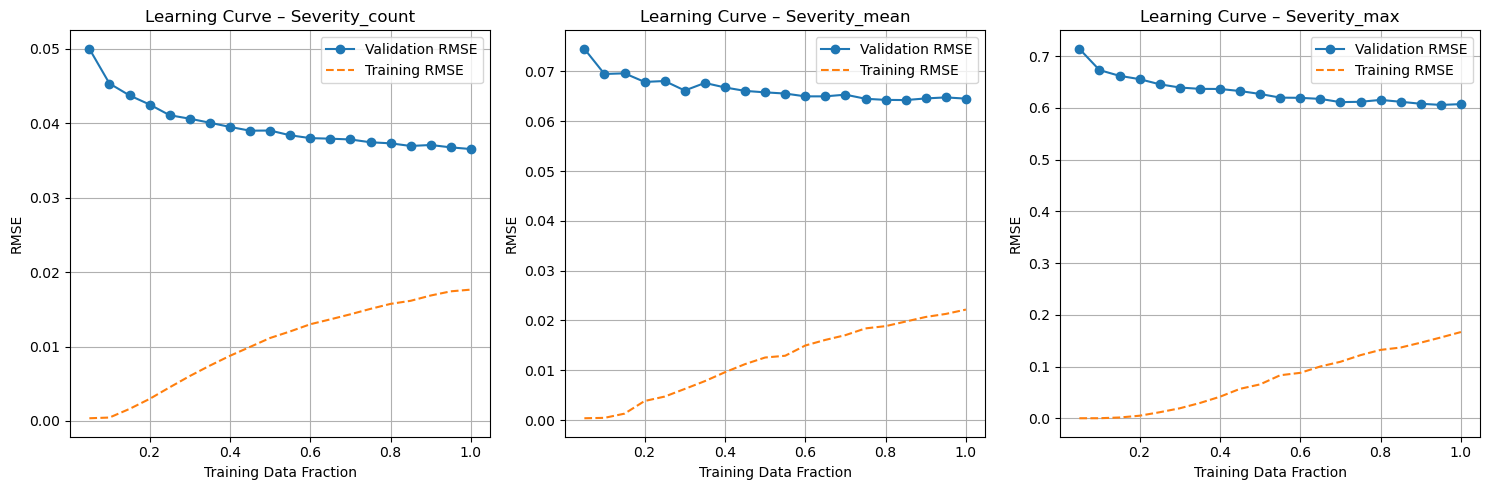

In [21]:
best_params = {
    'Severity_count': {'max_depth': 4, 'learning_rate': 0.2},
    'Severity_mean':   {'max_depth': 4, 'learning_rate': 0.2},
    'Severity_max':   {'max_depth': 5, 'learning_rate': 0.2}
}

learning_curve_results = {}
for target, params in best_params.items():
    print(f"\nLearning Curve for {target}")
    model = XGBRegressor(
        **params,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror'
    )
    lc_result = manual_learning_curve_regression(model, X, y[target], train_fractions=np.linspace(0.05, 1.0, 20), k=5)
    learning_curve_results[target] = lc_result

plt.figure(figsize=(15, 5))

for i, (target, df) in enumerate(learning_curve_results.items()):
    plt.subplot(1, 3, i + 1)
    plt.plot(df['fraction'], df['val_RMSE_mean'], 'o-', label='Validation RMSE')
    plt.plot(df['fraction'], df['train_RMSE_mean'], '--', label='Training RMSE')
    plt.xlabel("Training Data Fraction")
    plt.ylabel("RMSE")
    plt.title(f"Learning Curve – {target}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


--- SHAP for Severity_count ---


/var/folders/t9/qfn6nmkj7qn5hz4ksvt8v0bc0000gn/T/ipykernel_51161/3272336938.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, show=False)


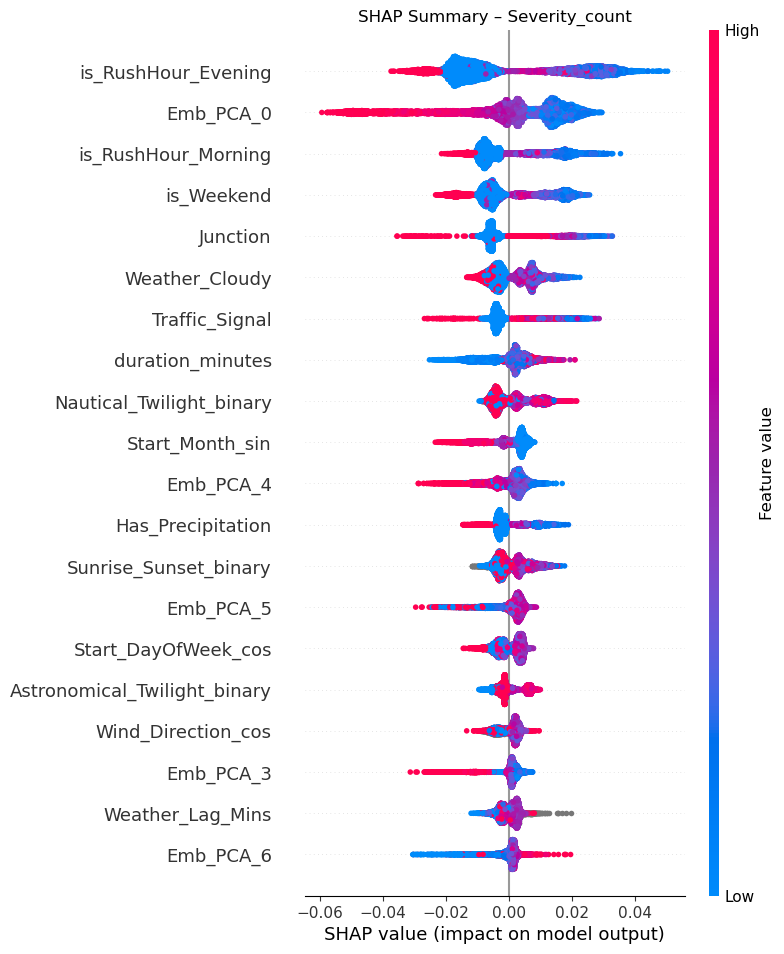

--- SHAP for Severity_mean ---


/var/folders/t9/qfn6nmkj7qn5hz4ksvt8v0bc0000gn/T/ipykernel_51161/3272336938.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, show=False)


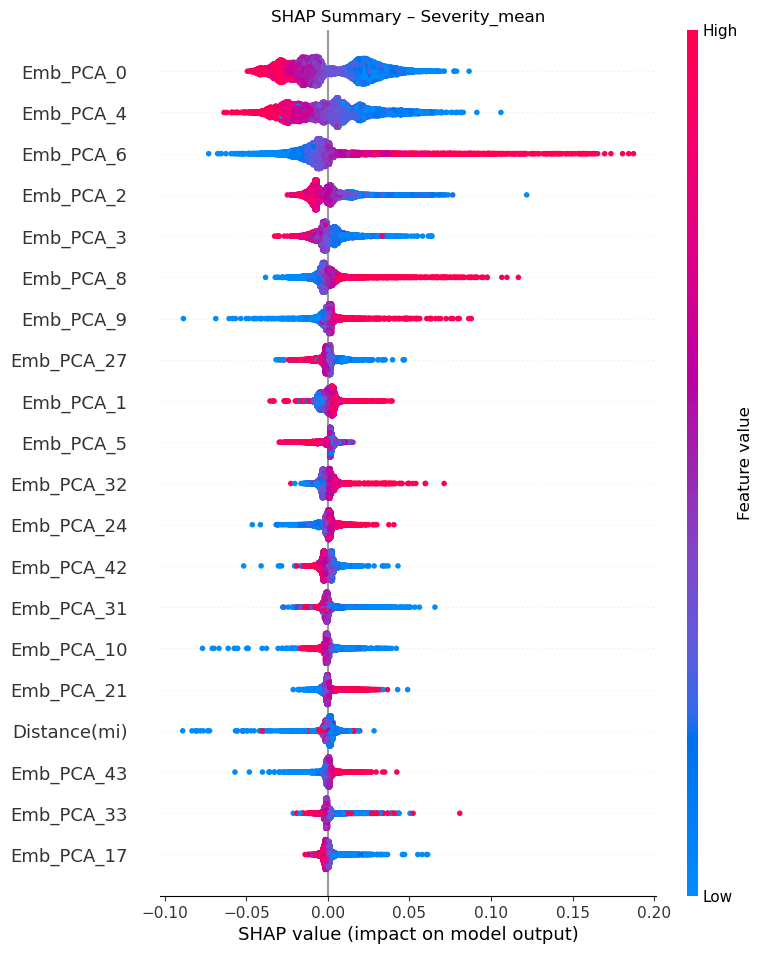

--- SHAP for Severity_max ---


/var/folders/t9/qfn6nmkj7qn5hz4ksvt8v0bc0000gn/T/ipykernel_51161/3272336938.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, show=False)


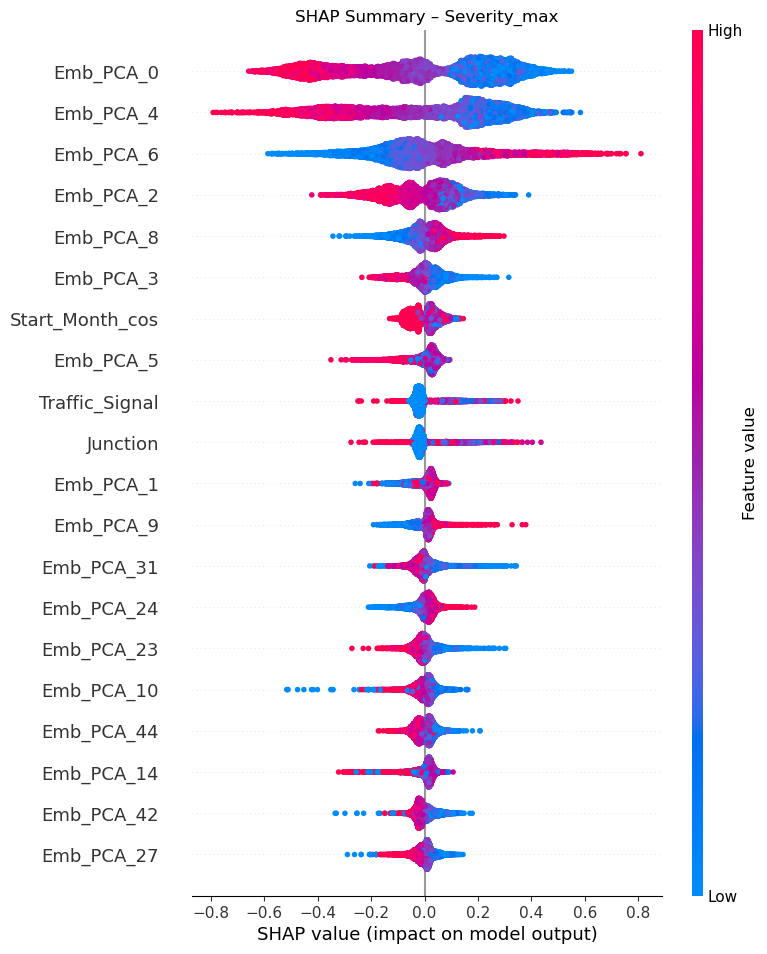

In [19]:
for target, params in best_params.items():
    print(f"--- SHAP for {target} ---")
    model = XGBRegressor(
        **params,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror'
    )
    model.fit(X, y[target])

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    shap.summary_plot(shap_values, X, show=False)
    plt.title(f"SHAP Summary – {target}")
    plt.show()
